In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import glob
import os
import peakutils
import logging
import datetime
import warnings
from lmfit.models import PseudoVoigtModel, GaussianModel
from jupyterthemes import jtplot

In [2]:
from xps.xps_sw import *
from xps.xps_import import *
from xps.xps_analysis import *
from xps.xps_bg import *
from xps.xps_fits import *

jtplot.style('default', grid=False)
logging.getLogger().setLevel(logging.CRITICAL)
warnings.filterwarnings("ignore")

plt.rcParams['errorbar.capsize'] = 8
plt.rcParams['font.size'] = 18
plt.rc('font', size= 18)
plt.rc('legend', fontsize= 15)
plt.rc('xtick', labelsize= 18)
plt.rc('ytick', labelsize= 18)
plt.rc('axes', labelsize=18)
plt.rc('axes', titlesize=18)
plt.rcParams["xtick.major.size"] = 8

plt.rcParams['lines.linewidth'] = 4
asf = dict({'C_1s' : 0.296, 'O_1s' : 0.711, 'N_1s' : 0.477, 'Ba_3d' : 7.49,
            'Br_3p' : 1.054, 'Cu_2p' : 5.321, 'Ba_4d': 2.35, 'Na_1s' : 1.685,
           'In3d' : 4.359, 'Sn3d' : 4.725, 'Cl_2p' : 0.891, 'Si2p': 0.339})

In [3]:
def plot_xp_regions(experiments : list, regions : list, colors : list = [], ncols: int = 3, flag_shift: bool = False):
    """Subplots all regions of a list of experiments (unnormalised)"""
    rows = int(np.ceil(len(regions) / ncols))

    fig, ax = plt.subplots(rows, ncols, figsize=(16, 8))
    fig.add_subplot(111, frameon=False, xticks=[], yticks=[])  # Used for common xlabel and ylabel

    for i,r in enumerate(regions):
        enmx, comx = [], [] # Peak point lists
        for c,xp in enumerate(experiments):
            j, k = i//ncols, i%ncols

            if i == len(regions) - 1:   # Set labels from last region
                lb = xp.name

            else:
                lb='__nolabel__'

            try:
                li = plot_region(xp, r, ax=ax[j][k], lb=lb)
                ax[j][k].legend()
                ax[j][k].invert_xaxis()
            except KeyError:    # Auto-exclude regions not recorded for a particular experiment
                pass
            if flag_shift:
                argmx = np.argmax(xp.dfx[r].counts)
                enmx.append(xp.dfx[r].energy.loc[argmx])
                comx.append(xp.dfx[r].counts.loc[argmx])

        ax[j][k].set_title(r)
        ax[j][k].set_yticks([])
        if flag_shift:  ax[j][k].plot(enmx, comx, '--k', lw=2.5)

        if len(experiments)%2 == 0:
            ax[j][k].invert_xaxis()
    plt.xlabel('\nEnergy [eV]', ha='center')
    plt.tight_layout(w_pad=0.5, h_pad=0.5, pad=0.1)
    return ax

def plot_fit_result(xp: XPS_experiment, region: str, fitRes: ModelResult = None,
                    lb : str = None, ax = None, col:str = None, offset: float = 0.3,
                    plot_comps: bool = True, flag_fill: bool = False):
    if ax == None : ax = plt.gca()
    if col == None: col = xp.color
    if lb == None: lb = xp.name
    if fitRes == None: fitRes = xp.fit[region]
        
    offset *= np.average(xp.dfx[region].dropna().counts.values)
    p1 = ax.scatter(xp.dfx[region].energy, xp.dfx[region].counts + offset,
                    color=col, label=lb, zorder = 1)

    x = xp.dfx[region].dropna().energy

    ax.plot(x, fitRes.best_fit + offset, '-', color=col)#, label='best fit, $\chi^2_N$ = %i' %fitRes.redchi)
#     ax.legend(loc='upper left')

    if plot_comps:
        comps = fitRes.eval_components(x=x)
        for compo in comps:
            posx = fitRes.best_values[compo+'center']
            colc = ax.plot(x, comps[compo], ls='dotted', lw=2, color=col, label='__nolabel__')[0].get_color()

            ax.vlines(x=posx, ymin=0, ymax=comps[compo].max(), linestyle='-', colors=col)
            ax.text(x=posx, y=comps[compo].max()*0.9, s='%.1f' %posx, fontsize=12)
            if flag_fill:
                ax.fill_between(x, y1 = 0, y2 = comps[compo], alpha=0.3, color=col)

    return ax, offset

def table_fit_area(exps: list, region: str):
    """Print a table with fit results and relative areas dict"""
    par_table = ['center', 'fwhm', 'amplitude', 'area']
    head = 'comp\t'

    for par in par_table: 
        head += '%s\t'%par

    print(head)

    for xp in exps:
        fit = xp.fit[region]
        for i, comp in enumerate(fit.components):
            pref = comp.prefix
            line = pref[:-1] + '\t'

            for par in par_table[:-1]:
                line += '%.2f\t '%fit.values[pref + par]        
            line += '%.2f'%xp.area[region+'_'+pref]

            print(line)

In [4]:
def n_layers(xpf: XPS_experiment, xp0: XPS_experiment, r_ml: float, region: str, mfp: float, takeoff: float):
    """Estimate number of layers from the attenuation in substrate (region) between an experiment
    with the layer xpf and a reference (clean) experiment xp0.
    For uncorrected thickness estimation (in nm), use function layer_thickness.
    Parameters:
    ------------
    - xpf: Experiment with substrate CL attenuated by layer.
    - xp0: Clean experiment for reference.
    - r_ml: Size of a Monolayer, in the same units as mfp
        (if the attenuation corresponds to sub-ML regime, correct for bare substrate contribution)
    - region: substrate region.
    - mfp: mean free path of the molecule conforming the layer (use QUASES to compute it).
        NOTE: Use EAL to account for elastic scattering, if negligible use IMFP.
    - takeoff: angle in degrees between the surface normal and the analyser entry.

    Returns:
    layers, dlayers: number layer and associated error
    -----------
    """
    #from invisible_cities.core.system_of_units import nm

    try:
        If = xpf.area[region]
        I0 = xp0.area[region]

    except KeyError:
        If = np.trapz(xpf.dfx[region].dropna().counts, dx=0.1)
        I0 = np.trapz(xp0.dfx[region].dropna().counts, dx=0.1)

    dIf = np.sqrt(If)
    dI0 = np.sqrt(I0)

    costh = np.cos(takeoff*np.pi/180)

    thick = mfp*costh*np.log(I0/If)
    dthick = mfp*costh*np.sqrt((dI0/I0)**2 + (dIf/If)**2)

    if thick < r_ml:
        layers = (If/I0 - 1) / (np.exp(- r_ml * costh / mfp) - 1)
        dlayers = layers * np.sqrt( (dIf/If)**2 + (dI0/I0)**2 )
    else:
        layers = thick / r_ml
        dlayers = dthick / r_ml

    xpf.area.update({'layers' : layers})
    xpf.area.update({'dlayers' : dlayers})

    return layers, dlayers

def arrange_coverages(experiments: list, inds: list,
                      r_ml: float, region: str, mfp: float, takeoff: float)->np.matrix:
    """Estimate n_layers for a list of experiments following the indices inds
    Parameters:
     - experiments: list of XPS_experiment to look into
     - inds: list of indices. It must be arranged such that each set of measurements
             has its reference (clean substrate) index at the end of each list.
             Example:  inds = [[0,1,2,3,5,7,8, 4], [9, 10]]
             will take experiments[4] as clean_substrate, and compute the thickness of experiments[0],
             experiments[1], experiments[2]... Then it will take experiments[10] as clean_substrate and
             compute the thickness for experiments[9]
     - all other params must be passed as for n_layers
    Returns:
    layers_res: matrix (M x 2), with column 0 is the mean value of n_layers and column 1 its error, and
    where M is the number of experiments passed for computation.
    """
    layers_res = []
    for lref in inds:
        for li in lref[:-1]:
            lay, dlay = n_layers(xpf=experiments[li], xp0=experiments[lref[-1]],
                                           r_ml = r_ml, region=region, mfp=mfp, takeoff=takeoff) 
            experiments[li].area['layers'] = lay
            experiments[li].area['dlayers'] = dlay
            
            layers_res.append((lay, dlay))
    layers_res = np.matrix(layers_res)
    return layers_res

def plot_coverages(experiments, label='__nolabel__'):
    layers, dlayers = [], []
    names = []
    for xp in experiments:
        try:
            layers.append(xp.area['layers'])
            dlayers.append(xp.area['dlayers'])
            names.append(xp.name.replace('_', ' ') )
        except KeyError:
            pass

    ax = plt.gca()
    ax.errorbar(x=layers, xerr=dlayers, y=names, fmt='o', markersize=10, label=label)
    ax.set_xlabel('Layers')
    ax.legend()

# Sample 2 from May 10th, BaCl2

In [208]:
path = '/Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_10_Au111/**/*.uxy'

files = glob.glob(path, recursive=True)
files.sort()
file_clean = files[-1]
files[1:] = files[:-1]
files[0] = file_clean
files

['/Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_10_Au111/proc/20210510_Au111_clean2.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_10_Au111/proc/20210510_Au111_FBI_subl_30min.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_10_Au111/proc/20210510_Au111_FBI_subl_30min_BaCl2_30s.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_10_Au111/proc/20210510_Au111_FBI_subl_30min_BaCl2_60s.uxy']

In [209]:
samp2 = [read_processed_xp(f) for f in files]
cols = ['r', 'g', 'b', 'y']
for xp, c in zip(samp2, cols):
    xp.color = c

[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_10_Au111/proc/20210510_Au111_clean2.uxy.ft', returning empty fit dict
[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_10_Au111/proc/20210510_Au111_FBI_subl_30min_BaCl2_60s.uxy.ft', returning empty fit dict


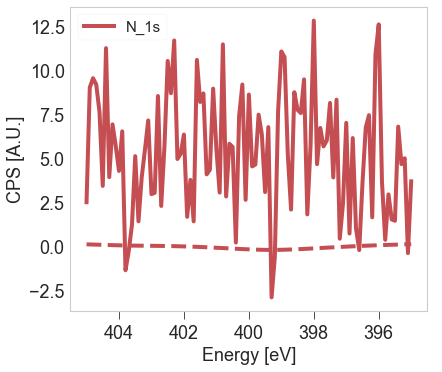

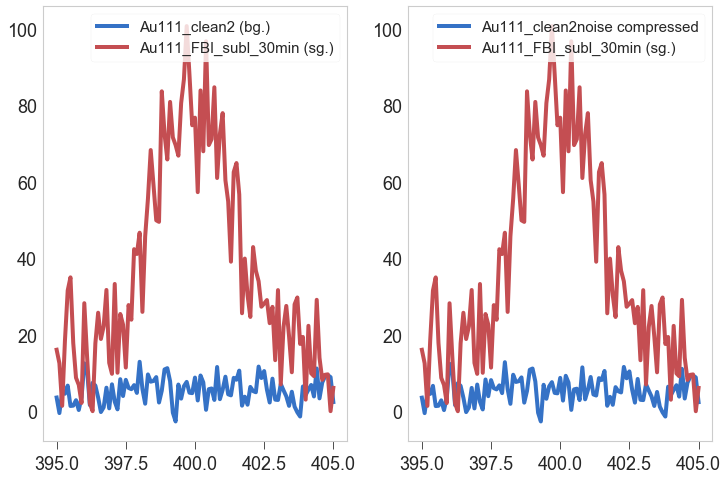

In [210]:
samp2[0] = subtract_als_bg(samp2[0], 'N_1s')
compress_noisy_region(samp2[0], samp2[1], 'N_1s', inplace=True);

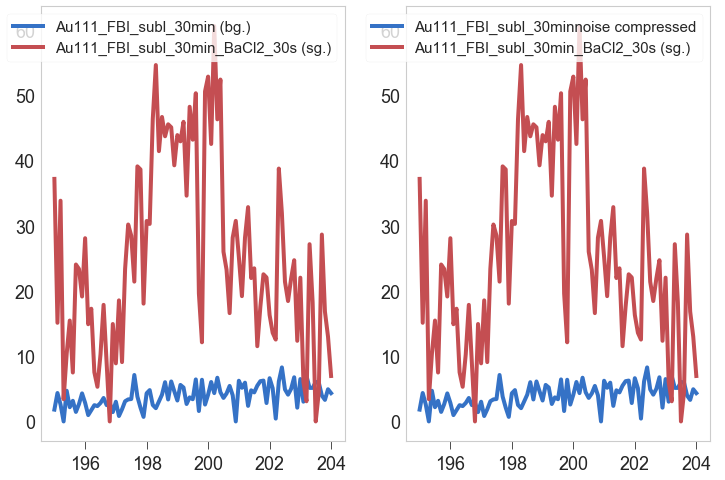

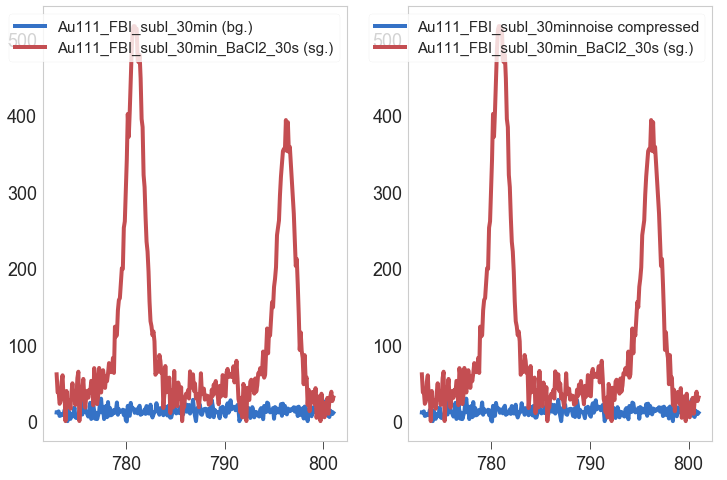

In [211]:
compress_noisy_region(samp2[1], samp2[2], 'Cl_2p', inplace=True);
compress_noisy_region(samp2[1], samp2[2], 'Ba_3d', inplace=True);

In [212]:
trim_spectra(samp2[0], samp2[1], 'O_1s', inplace=True)
trim_spectra(samp2[2], samp2[1], 'N_1s', inplace=True);

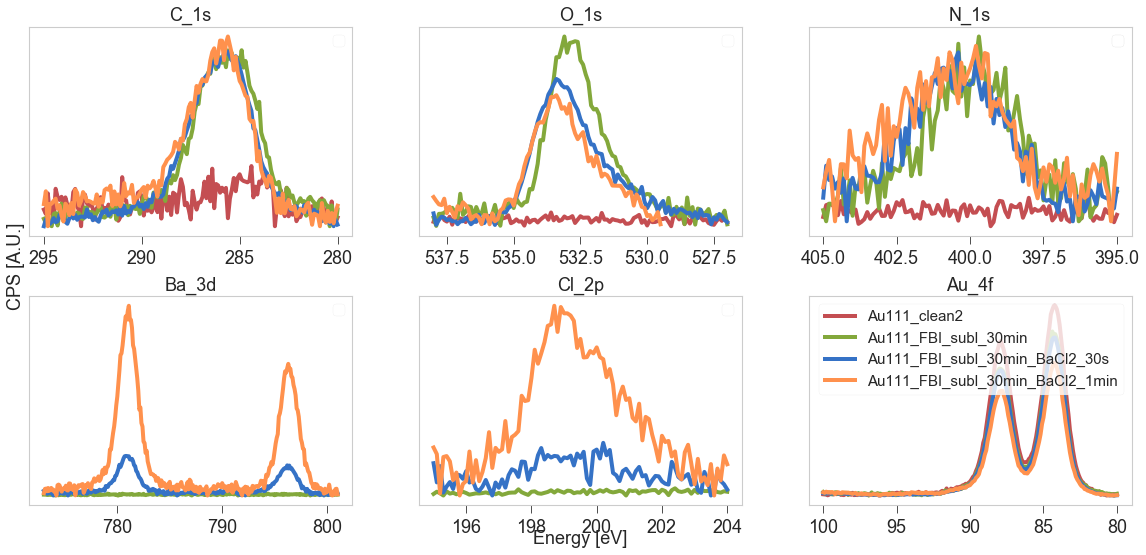

In [213]:
regs = ['C_1s', 'O_1s', 'N_1s', 'Ba_3d', 'Cl_2p', 'Au_4f']

plot_xp_regions(samp2, regs, ncols=3);
# plt.gcf().savefig('/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_26_Cu/Unscaled_exps.png', dpi=200)

## Proper reference subtraction from Au clean

In [214]:
path = '/Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_10_Au111/**/*.xy'

rawfiles = glob.glob(path, recursive=True)
rawfiles.sort()
rawfile_clean = rawfiles[-1]
rawfiles[1:] = rawfiles[:-1]
rawfiles[0] = rawfile_clean
rawfiles

['/Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_10_Au111/20210510_Au111_clean2.xy',
 '/Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_10_Au111/20210510_Au111_FBI_subl_30min.xy',
 '/Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_10_Au111/20210510_Au111_FBI_subl_30min_BaCl2_30s.xy',
 '/Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_10_Au111/20210510_Au111_FBI_subl_30min_BaCl2_60s.xy']

In [217]:
rawxps = [xps_data_import(f) for f in rawfiles]
cols = ['r', 'g', 'b', 'y']
for xp, c in zip(rawxps, cols):
    xp.color = c

In [218]:
trim_spectra(rawxps[0], rawxps[1], 'O_1s', inplace=True);

[(550, 540)]

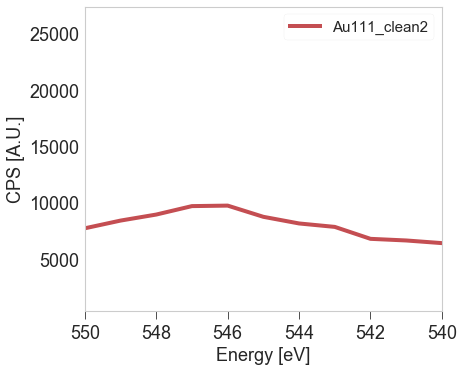

In [295]:
plot_region(rawxps[0], 'overview')
plt.gca().set(xlim=(550, 540))

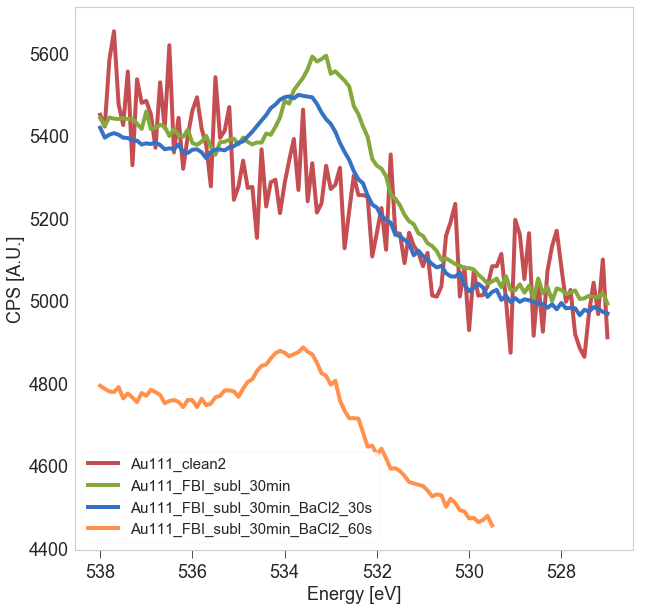

In [223]:
smooth = gaussian_smooth(rawxps[0], 'O_1s', sigma=2)
# plot_region(smooth, 'O_1s')

plt.figure(figsize=(10,10))
plot_region(rawxps[0], 'O_1s')
plot_region(rawxps[1], 'O_1s')
plot_region(rawxps[2], 'O_1s')
plot_region(rawxps[3], 'O_1s')
plt.gca().invert_xaxis()

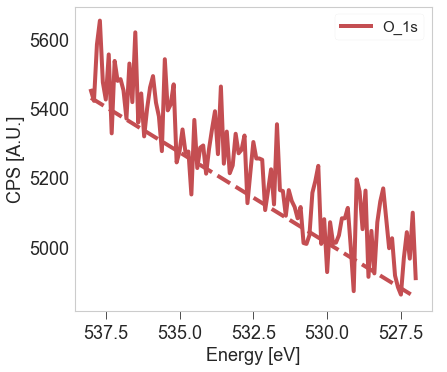

In [224]:
subtract_linear_bg(rawxps[0], 'O_1s');

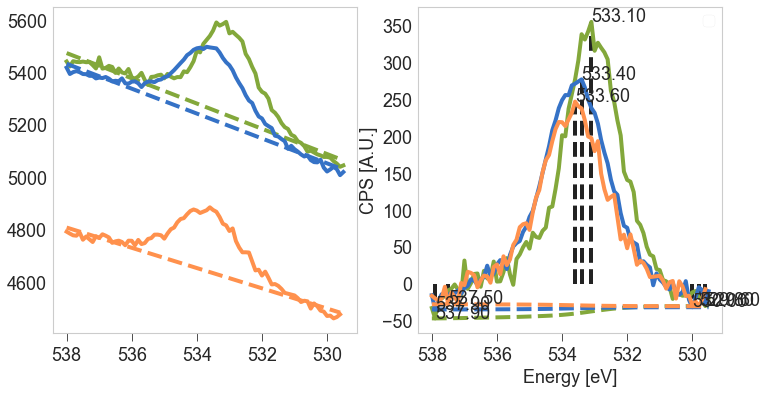

In [225]:
bg_exps = []
fig, ax = plt.subplots(1, 2, sharex=True, figsize=(12, 6))
for xp in rawxps[1:]:
    bgxp = crop_spectrum(xp, 'O_1s', edw=529.5)    
    bgxp = subtract_linear_bg(bgxp, 'O_1s', ax=ax[0])
    bgxp = subtract_shirley_bg(bgxp, 'O_1s', maxit=100, ax=ax[1])
#     fix_tail_bg(bgxp, 'O_1s', eup=530.6, inplace=True, ax=ax[2])
    bg_exps.append(bgxp)
ax[1].invert_xaxis()

Modify user pars


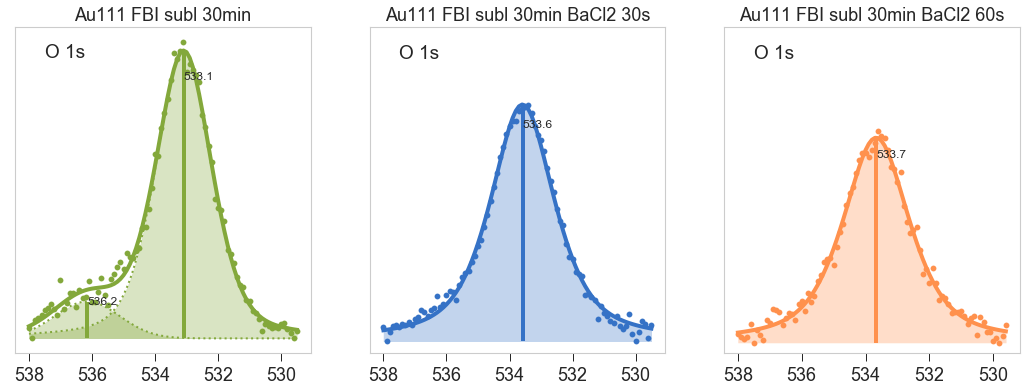

In [228]:
fig, ax = plt.subplots(1, 3, sharex=False, figsize=(18, 6), )

r = 'O_1s'
for i, xp in enumerate(bg_exps):
    xp.area, xp.fit = {}, {}
    Fn = XPFit(xp, region = r)
    if i == 0: 
        Fn.preset_pars('v2_sigma', 1.21431795)
        Fn.double_voigt(sepPt=533.5)
    else: Fn.voigt()
    Fn.set_areas()
    plot_fit_result(xp, r, fitRes=xp.fit[r], ax=ax[i], offset=0,
                    flag_fill=True, plot_comps=True)
    ax[i].set(title=xp.name.replace('_', ' '), xlabel='', ylabel='', yticks=[], 
                 ylim=(ax[i].get_ylim()[0], ax[0].get_ylim()[1]))
    ax[i].invert_xaxis()
    ax[i].tick_params('both', length=8, width=1, which='major')
    ax[i].text(s='O 1s', x=537.5, y=ax[0].get_ylim()[1]*0.9, fontsize=19)


Text(537, 405.15692651634777, 'O 1s')

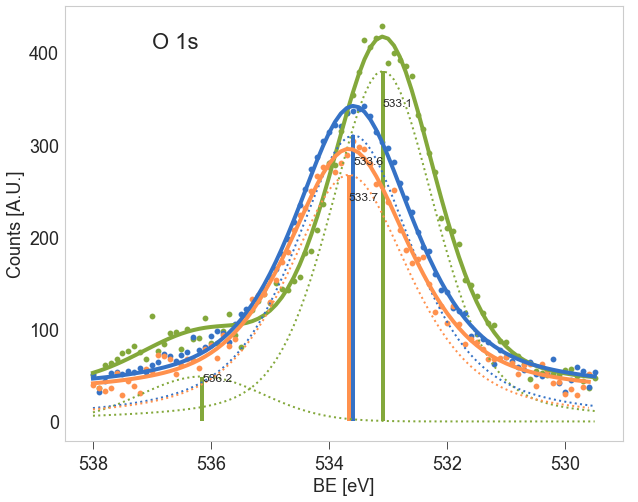

In [230]:
region = 'O_1s'
plt.figure(figsize=(10, 8))
plot_fit_result(bg_exps[0], region)
plot_fit_result(bg_exps[1], region)
plot_fit_result(bg_exps[2], region)

plt.gca().invert_xaxis()
plt.gca().set(xlabel='BE [eV]', ylabel='Counts [A.U.]')
plt.gca().text(s='O 1s', x=537, y=plt.gca().get_ylim()[1] * 0.9, fontsize=22)

## Stoichiometry

'Ba_3d' region does not exist in Au111_clean2
'Cl_2p' region does not exist in Au111_clean2
'Au_4f' , asf missing, returning raw area
'Au_4f' , asf missing, returning raw area
'Au_4f' , asf missing, returning raw area
'Au_4f' , asf missing, returning raw area


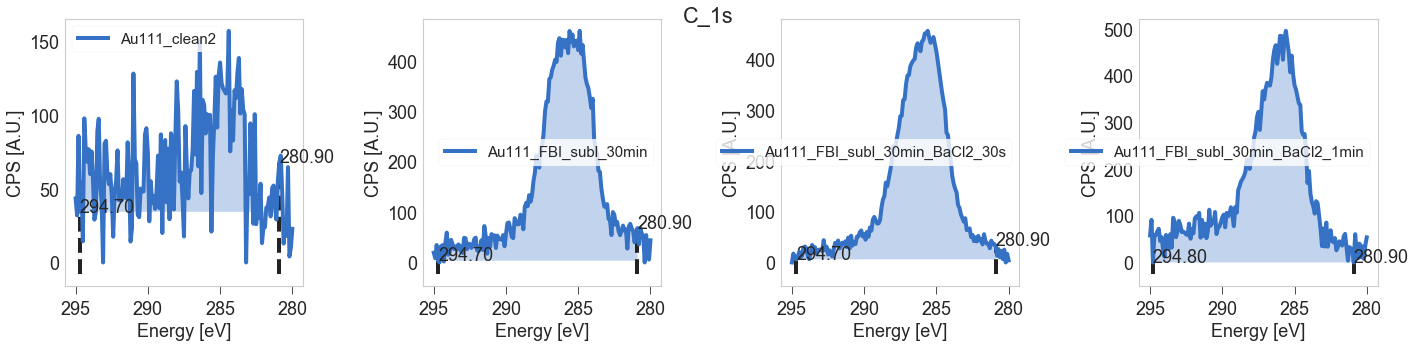

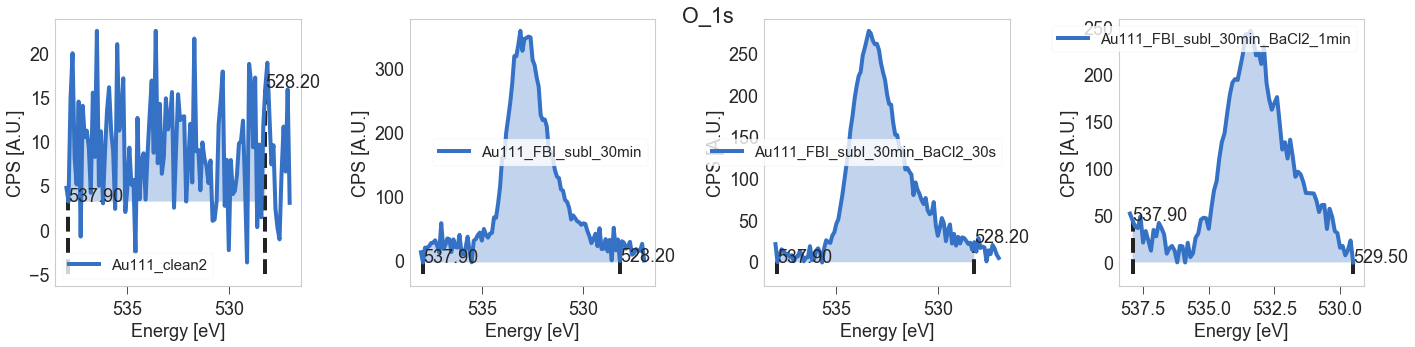

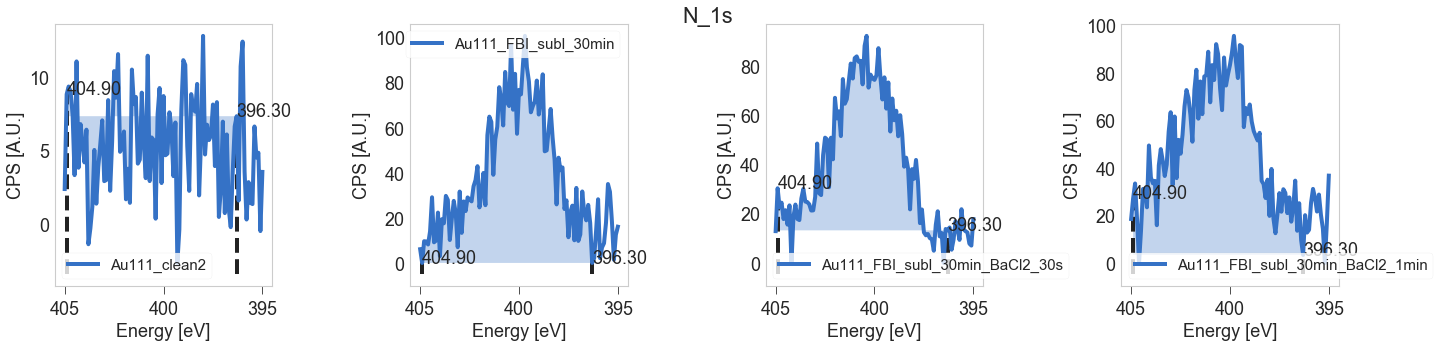

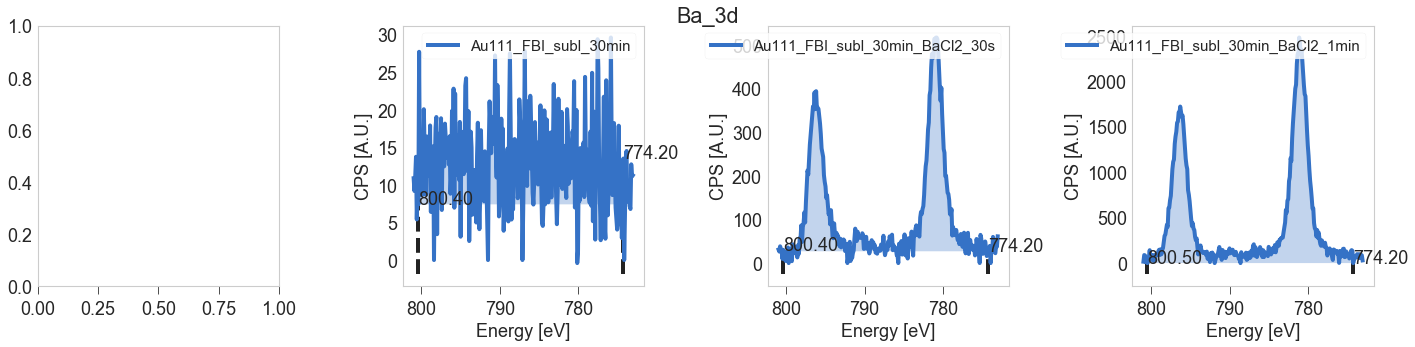

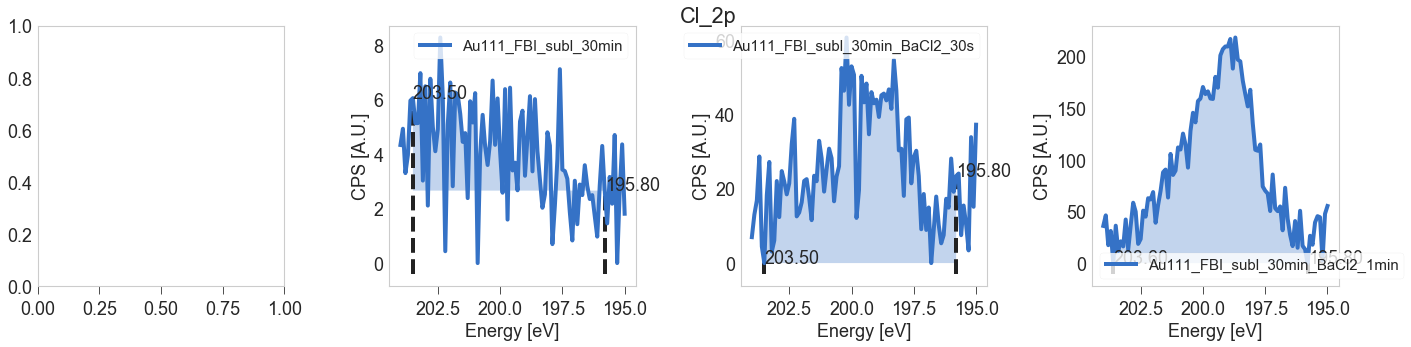

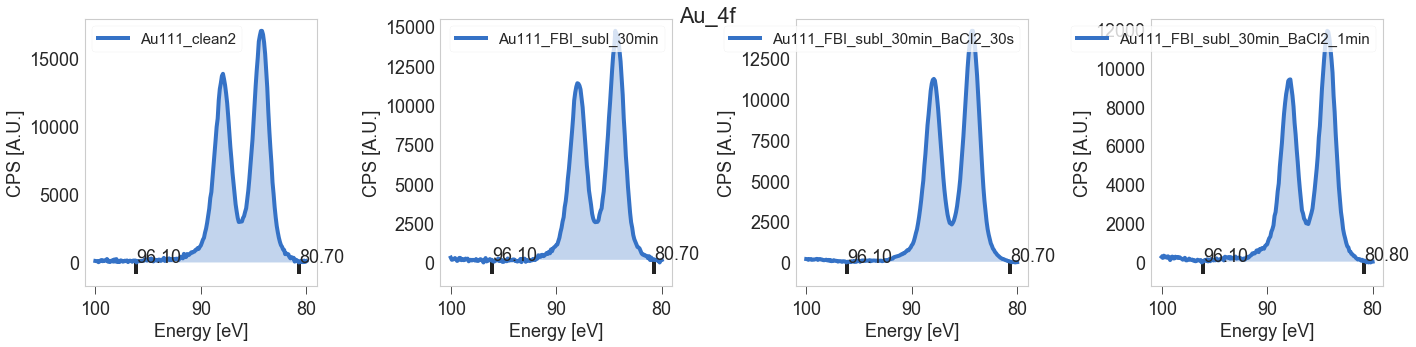

In [301]:
for r in regs:
    integrateRegions(samp2, r, asf=asf)

In [303]:
num, denom = (('N_1s', 'C_1s', 'C_1s' ), ('O_1s', 'N_1s', 'O_1s',))
make_stoichometry_table(samp2,  num=num, denom=denom, sep=' \t ')

num, denom = ('N_1s', 'Cl_2p'), ( 'Ba_3d', 'Ba_3d')
make_stoichometry_table([samp2[2],samp2[3]],  num=num, denom=denom, sep=' \t ')


Experiment	N_/O_	C_/N_	C_/O_	
Au111_clean2 	 0.78  	  31.72  	  24.85  	  
Au111_FBI_subl_30min 	 0.53  	  9.68  	  5.18  	  
Au111_FBI_subl_30min_BaCl2_30s 	 0.66  	  8.73  	  5.75  	  
Au111_FBI_subl_30min_BaCl2_1min 	 0.87  	  8.50  	  7.43  	  
Experiment	N_/Ba_	Cl_/Ba_	
Au111_FBI_subl_30min_BaCl2_30s 	 2.05  	  0.62  	  
Au111_FBI_subl_30min_BaCl2_1min 	 0.58  	  0.55  	  


In [200]:
2/3

0.6666666666666666

## Coverages
From https://www.sciencedirect.com/topics/chemistry/barium-chloride
The possible BaCl$_2$ cell types and sizes are:

- Fe2P type: a = 4.059 Å, b = c = 7.083 Å, α = 120°, β = γ = 90°, cell volume = 176.31 Å$^3$

- PbCl2 type, SG = mP24: a = 4.604 Å, b = 8.613 Å, c = 11.901 Å, α = 92.6°, β = γ = 90°, cell volume = 471.48 Å$^3$

So an estimate thickness of each BaCl$_2$ ML is the minimum cell size: 5 Å = 0.5 nm, in case we need it at some point for density estimation.

In [150]:
# Coverage with FBI: IMFP = 1.86 nm
inds = [[1, 0]]
layers_fbi = arrange_coverages(samp2, inds,
                               r_ml = 1.1*nm, region='Au_4f', mfp = 3.87*nm, takeoff = 10)

# Coverage with BaCl2: IMFP = 1.35 nm
# Take previous stage (only FBI) as reference
inds = [[2, 1]]
layers_fbi = arrange_coverages(samp2, inds,
                               r_ml = 1*nm, region='Au_4f', mfp = 2.55*nm, takeoff = 10)

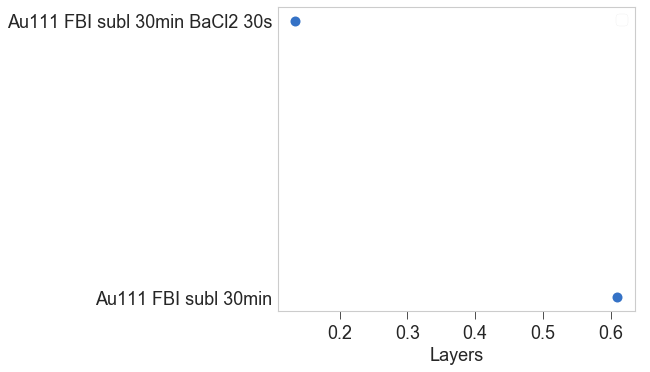

In [152]:
plot_coverages(samp2)

## Fits

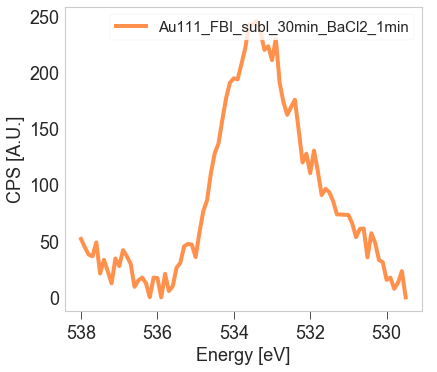

In [236]:
plot_region(samp2[3], 'O_1s')

TypeError: Cannot specify both 'axis' and any of 'index' or 'columns'.

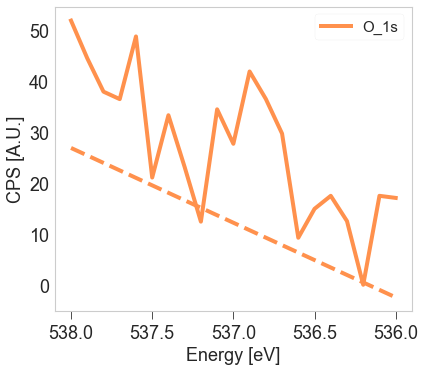

In [282]:
# fix_tail_bg(samp2[3], 'O_1s', edw=535.9)
xp = samp2[3]
region = 'O_1s'
eup = None
edw = 535.9
xpf = deepcopy(xp)
ax = plt.gca()

xpcrop = crop_spectrum(xpf, region, eup=eup, edw=edw)  # Crop the tail to fix bg subtraction
xpcropBg = subtract_als_bg(xpcrop, region, ax=ax)           # Subtract ALS bg

dfshort = xpcropBg.dfx[region]                         # Set energy column as index for the whole and the cropped data
dfshort.set_index('energy', drop=False, inplace=True)
dfWhole = xpf.dfx[region]
dfWhole.set_index('energy', drop=False, inplace=True)

roindex = [round(i, ndigits=1) for i in dfshort.dropna()['counts'].index]
dfshort.dropna()['counts'].index = roindex

roindex = [round(i, ndigits=1) for i in dfWhole.dropna()['counts'].index]
dfWhole.reindex(index = roindex)

In [267]:
# samp2[3].dfx
# xpcropBg.dfx[region]
# xpf.dfx[region]
# dfWhole['counts'].dropna().index#.loc[537]


Modify user pars
Modify user pars
Modify user pars
Modify user pars


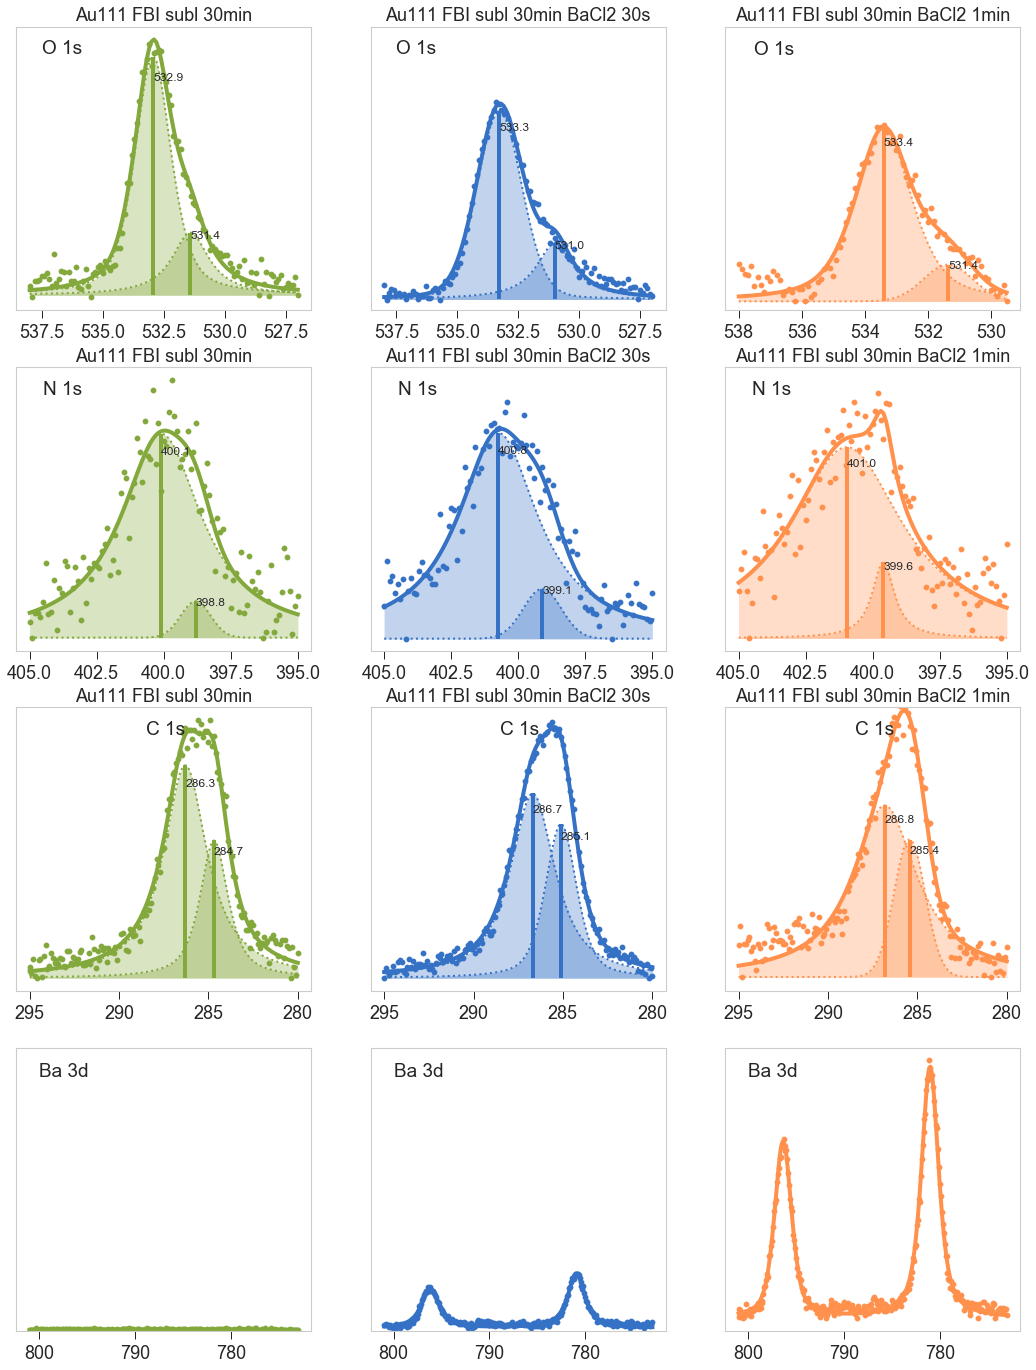

In [290]:
fig, ax = plt.subplots(4, 3, sharex=False, figsize=(18, 24), )

r = 'O_1s'
for i, xp in enumerate(samp2[1:]):
    Fn = XPFit(xp, region = r)
    Fn.preset_pars('v1_sigma', 0.92)
    Fn.double_voigt(sepPt=531.5)
#     Fn.voigt()
    Fn.set_areas()
    plot_fit_result(xp, r, fitRes=xp.fit[r], ax=ax[0][i], offset=0,
                    flag_fill=True, plot_comps=True)
    ax[0][i].set(title=xp.name.replace('_', ' '), xlabel='', ylabel='', yticks=[], 
                 ylim=(ax[0][i].get_ylim()[0], ax[0][0].get_ylim()[1]))
    ax[0][i].invert_xaxis()
    ax[0][i].tick_params('both', length=8, width=1, which='major')
    ax[0][i].text(s='O 1s', x=537.5, y=ax[0][0].get_ylim()[1]*0.9, fontsize=19)

r = 'N_1s'
for i, xp in enumerate(samp2[1:]):
    Fn = XPFit(xp, region = r)
#     Fn.preset_pars('v1_sigma', 0.92)
    Fn.double_voigt(sepPt=400)
#     Fn.voigt()
    Fn.set_areas()
    plot_fit_result(xp, r, fitRes=xp.fit[r], ax=ax[1][i], offset=0,
                    flag_fill=True, plot_comps=True)
    ax[1][i].set(title=xp.name.replace('_', ' '), xlabel='', ylabel='', yticks=[], 
                 ylim=(ax[1][i].get_ylim()[0], ax[1][0].get_ylim()[1]))
    ax[1][i].invert_xaxis()
    ax[1][i].tick_params('both', length=8, width=1, which='major')
    ax[1][i].text(s='N 1s', x=404.5, y=ax[1][0].get_ylim()[1]*0.9, fontsize=19)

r = 'C_1s'
for i, xp in enumerate(samp2[1:]):
    Fn = XPFit(xp, region = r)
    if i == 2: Fn.preset_pars('v1_sigma', 1.033460)
    Fn.double_voigt(sepPt=286)
#     Fn.voigt()
    Fn.set_areas()
    plot_fit_result(xp, r, fitRes=xp.fit[r], ax=ax[2][i], offset=0,
                    flag_fill=True, plot_comps=True)
    ax[2][i].set(title=xp.name.replace('_', ' '), xlabel='', ylabel='', yticks=[], 
                 ylim=(ax[2][i].get_ylim()[0], ax[2][0].get_ylim()[1]))
    ax[2][i].invert_xaxis()
    ax[2][i].tick_params('both', length=8, width=1, which='major')
    ax[2][i].text(s='C 1s', x=288.5, y=ax[2][0].get_ylim()[1]*0.9, fontsize=19)

r = 'Ba_3d'
li, _ = plot_fit_result(samp2[3], r, fitRes=samp2[3].fit[r], ax=ax[3][1], flag_fill=True, plot_comps=False)
lim = li.get_ylim()
ax[3][1].cla()
for i,xp in enumerate(samp2[1:]):
    Fn = XPFit(xp, region = r)
    Fn.double_voigt()

    li = plot_fit_result(xp, r, fitRes=xp.fit[r], ax=ax[3][i], flag_fill=True, plot_comps=False)
    ax[3][i].set(xlabel='', ylabel='', yticks=[], ylim=lim)
    ax[3][i].invert_xaxis()
    ax[3][i].tick_params('both', length=8, width=1, which='major',)
    ax[3][i].text(s='Ba 3d', x=800, y=lim[1]*0.9, fontsize=19)
# plt.tight_layout(w_pad=0.5, h_pad=0.5, pad=0.1)
# ax[2][0].legend(list(li.get_lines()), labels = [xp.name for xp in samp2[:0:-1]], ncol=len(selection),
#             loc="upper left", bbox_to_anchor=(0.1, 1.2))  

In [288]:
samp2[2].fit['C_1s'].best_values['v1_sigma']

1.0334600519416277

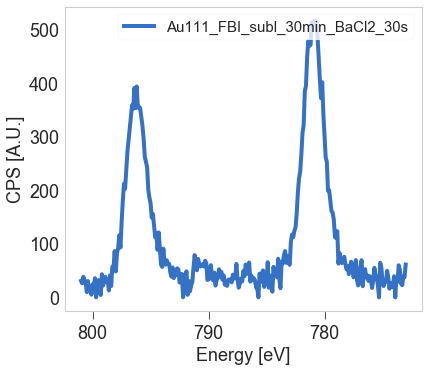

In [140]:
plot_region(samp2[2], 'Ba_3d')

In [76]:
for xp in samp2[1:]:
    print(xp.fit['O_1s'].best_values['v1_sigma'])

0.97172
0.97172


In [103]:
area_big = []
for xp in samp2[1:]:
    area_big.append(xp.area['O_1s_v1_'])
    print(xp.area['O_1s_v1_'])
# area_big.append(selection[4].area['O_1s_v1_'])

0.23360391743226427
0.2405710427494555


Text(537, 371.01033957613885, 'O 1s')

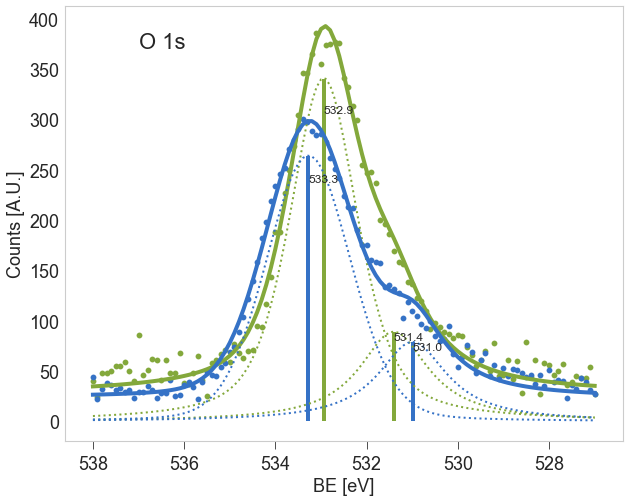

In [146]:
region = 'O_1s'
plt.figure(figsize=(10, 8))
plot_fit_result(samp2[1], region)
plot_fit_result(samp2[2], region)
plt.gca().invert_xaxis()
plt.gca().set(xlabel='BE [eV]', ylabel='Counts [A.U.]')
plt.gca().text(s='O 1s', x=537, y=plt.gca().get_ylim()[1] * 0.9, fontsize=22)

Text(404, 105.90827295241263, 'N 1s')

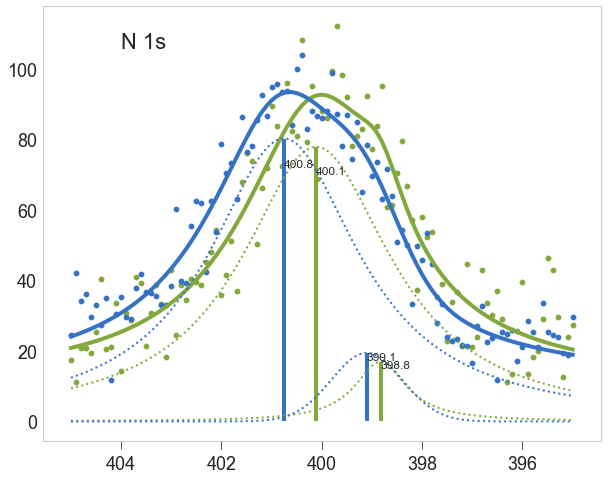

In [148]:
region = 'N_1s'
plt.figure(figsize=(10, 8))
plot_fit_result(samp2[1], region)
plot_fit_result(samp2[2], region)
plt.gca().invert_xaxis()
plt.gca().text(s='N 1s', x=404, y=plt.gca().get_ylim()[1] * 0.9, fontsize=22)

### Plot O_v1 vs subl Ba

Text(0, 0.5, 'Area O*-Ba / Total O 1s area')

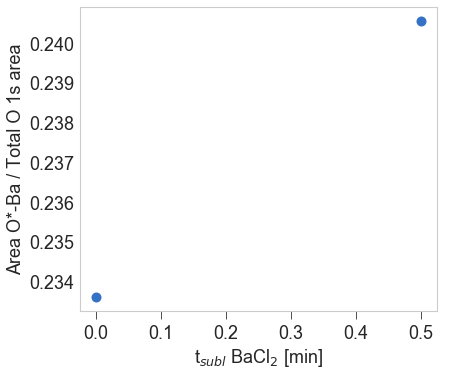

In [108]:
tsubl = [0, 0.5]
plt.plot(tsubl, area_big, 'o', markersize=10)
plt.xlabel('t$_{subl}$ BaCl$_2$ [min]')
plt.ylabel('Area O*-Ba / Total O 1s area')

In [109]:
for xp in samp2:
    write_processed_xp(xp.path, xp)

Storing of file /Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_10_Au111/proc/20210510_Au111_FBI_subl_30min.uxy.ft successful
Storing of file /Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_10_Au111/proc/20210510_Au111_FBI_subl_30min_BaCl2_30s.uxy.ft successful


### Other fits

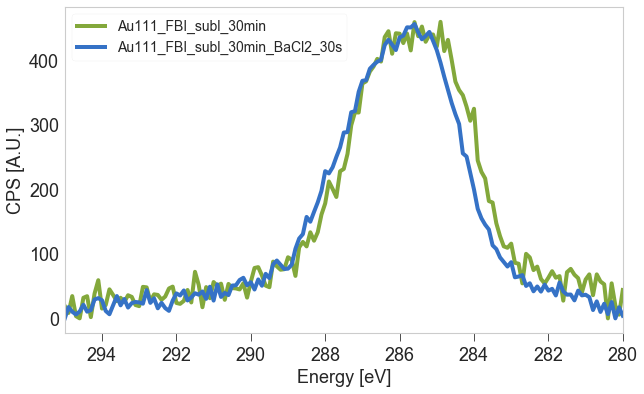

In [111]:
region = 'C_1s'
plt.figure(figsize=(10, 6))
plot_region(samp2[1], region)
plot_region(samp2[2], region)
plt.gca().set(xlim=(295, 280))
plt.legend(loc='upper left', fontsize = 14)

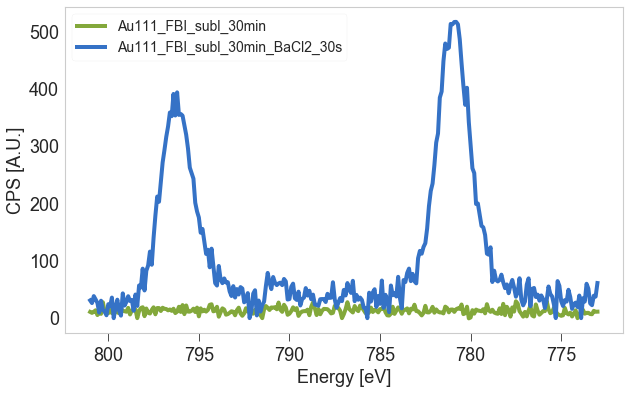

In [304]:
region = 'Ba_3d'
plt.figure(figsize=(10, 6))
plot_region(samp2[1], region)
plot_region(samp2[2], region)
plt.gca().invert_xaxis()
plt.legend(loc='upper left', fontsize = 14)

In [ ]:
regions = ['O_1s', 'N_1s', 'C_1s']
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
for i, region in enumerate(regions):
    plot_fit_result(samp1[1], region, ax=ax[i])
    plot_fit_result(samp1[2], region, ax=ax[i])
    ax[i].invert_xaxis()
    ax[i].text(s=region.replace('_',' '), x=ax[i].get_xlim()[0], y = ax[i].get_ylim()[1]*0.9)
    ax[i].set(yticks=[])
# plt.legend(loc='upper left')

# Sample 1 from May 4th, NaCl

In [312]:
path = '/Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_07_Au111/**/*.uxy'

files = glob.glob(path, recursive=True)
files.sort()
files[0], files[1] = files[1], files[0]
files

['/Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_07_Au111/proc/20210507_Au111_clean.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_07_Au111/proc/20210507_Au111_FBI_subl_30min.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_07_Au111/proc/20210508_Au111_FBI_subl_30min_NaCl_2min.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_07_Au111/proc/20210508_Au111_FBI_subl_30min_NaCl_2min_150ºC.uxy']

In [315]:
samp1 = [read_processed_xp(f) for f in files]
# for xp in samp1:
#     xp.name = xp.name.replace('17-Cu_','').replace('subl_','')

[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_07_Au111/proc/20210507_Au111_clean.uxy.ft', returning empty fit dict
[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_07_Au111/proc/20210507_Au111_FBI_subl_30min.uxy.ft', returning empty fit dict
[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_07_Au111/proc/20210508_Au111_FBI_subl_30min_NaCl_2min.uxy.ft', returning empty fit dict
[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_07_Au111/proc/20210508_Au111_FBI_subl_30min_NaCl_2min_150ºC.uxy.ft', returning empty fit dict


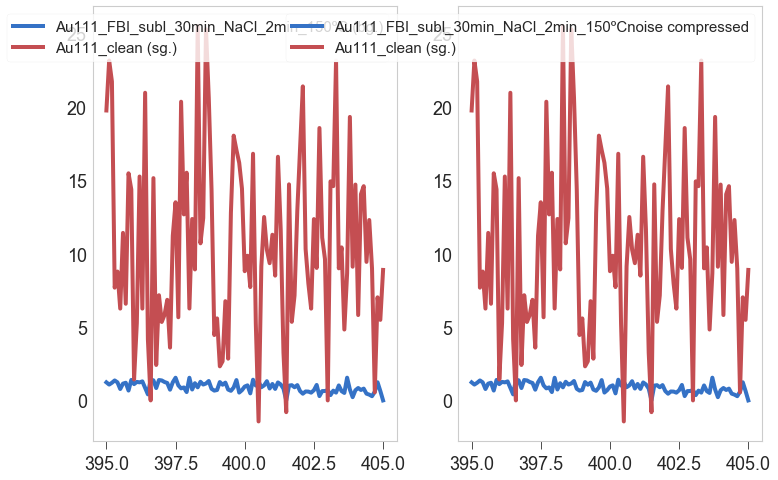

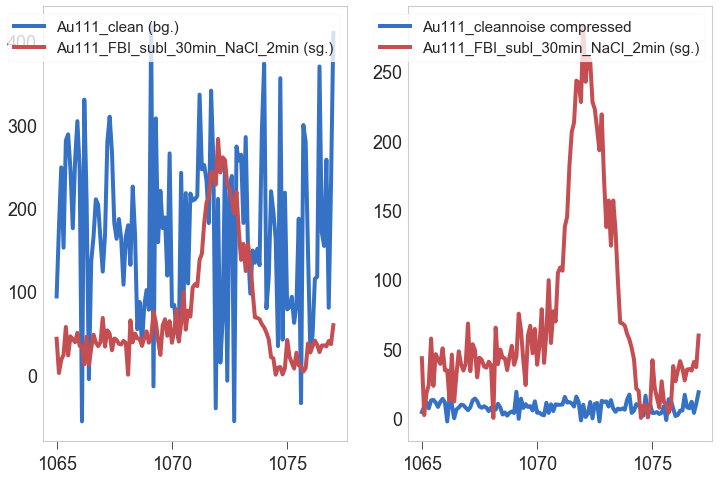

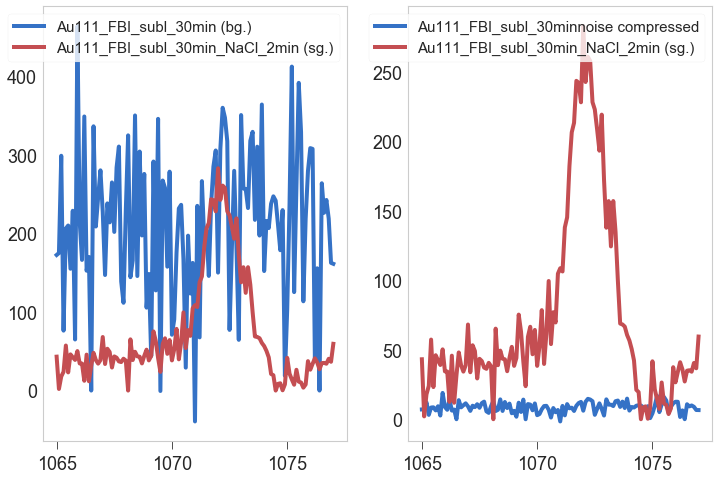

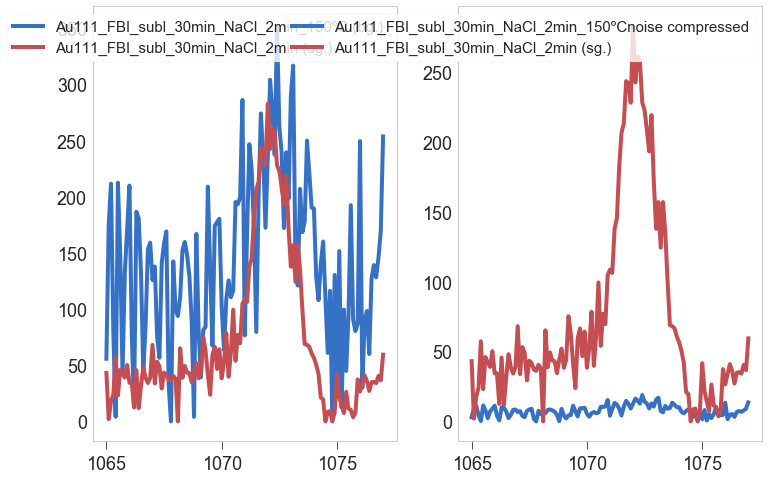

In [322]:
compress_noisy_region(samp1[3], samp1[0], 'N_1s', inplace=True);
compress_noisy_region(samp1[0], samp1[2], 'Na_1s', inplace=True);
compress_noisy_region(samp1[1], samp1[2], 'Na_1s', inplace=True);
compress_noisy_region(samp1[3], samp1[2], 'Na_1s', inplace=True);

crop_spectrum(samp1[0], 'O_1s', eup=537, edw=530, inplace=True)
for xp in samp1[1:]:
    trim_spectra(xp, samp1[0], 'O_1s', inplace=True)

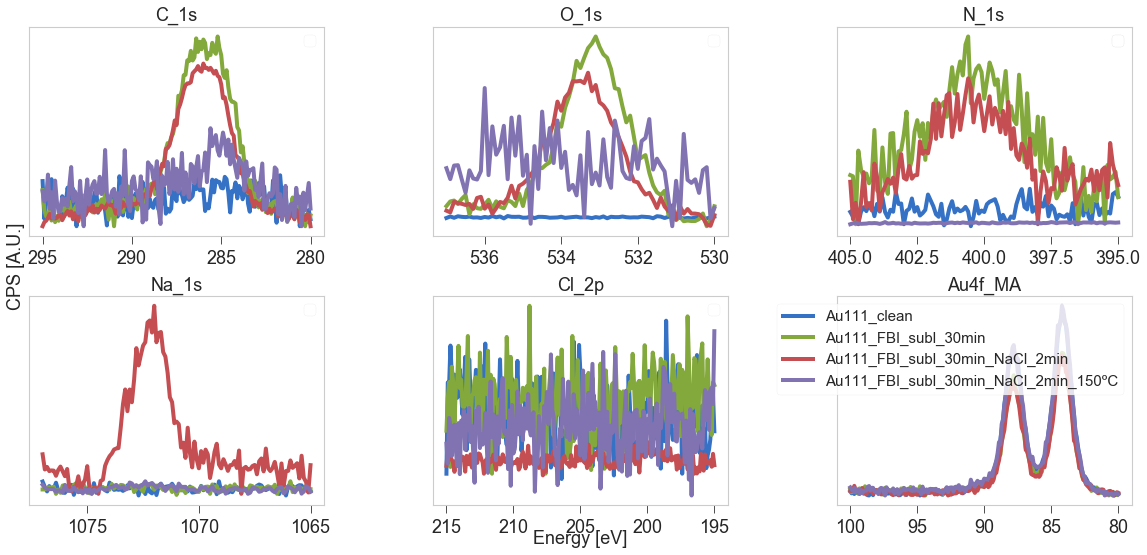

In [323]:
regs = ['C_1s', 'O_1s', 'N_1s', 'Na_1s', 'Cl_2p', 'Au4f_MA']

plot_xp_regions(samp1, regs, ncols=3);
# plt.gcf().savefig('/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/Unscaled_exps.png', dpi=200)

In [22]:
for r in regs[:3]:
    enmx = []
    comx = []
    for xp in samp1:
        argmx = np.argmax(xp.dfx[r].counts)
        enmx.append(xp.dfx[r].energy.loc[argmx])
        comx.append(xp.dfx[r].counts.loc[argmx])
    print(r, enmx[0] - enmx[1])

C_1s 0.30000000000001137
O_1s 0.5
N_1s 0.5999999999999659


## Stoichiometry

'Au4f_MA' , asf missing, returning raw area
'Au4f_MA' , asf missing, returning raw area
'Au4f_MA' , asf missing, returning raw area
'Au4f_MA' , asf missing, returning raw area


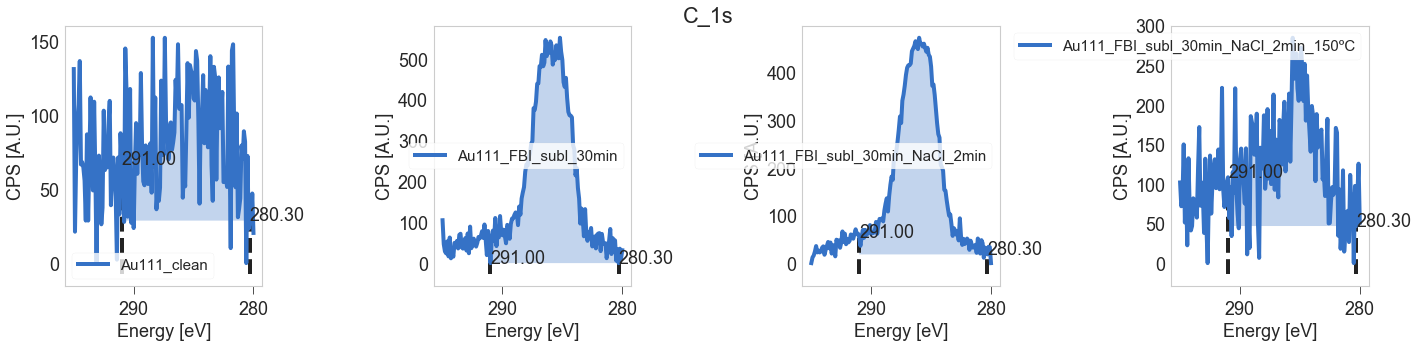

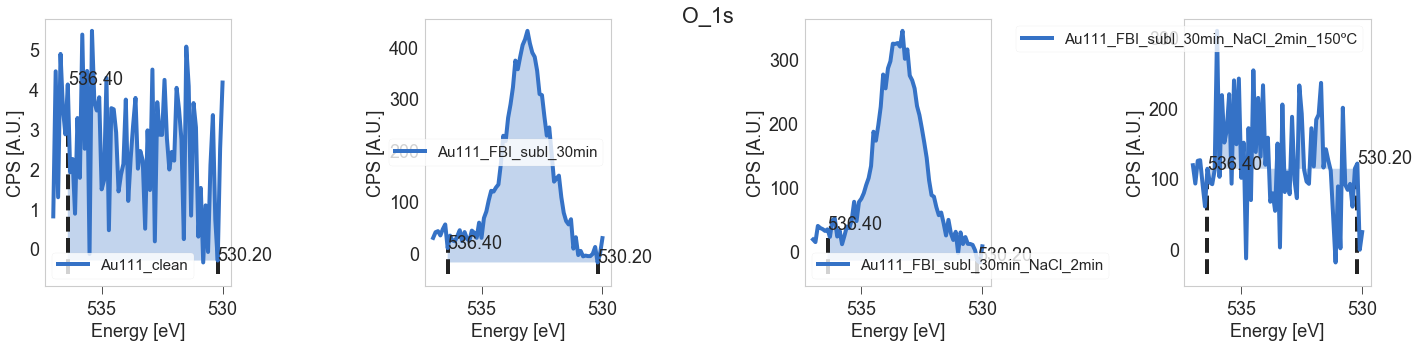

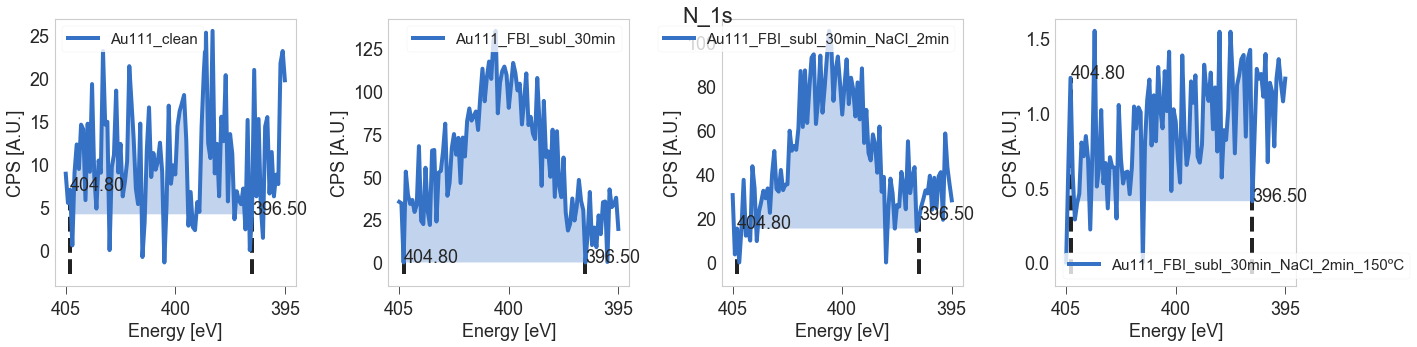

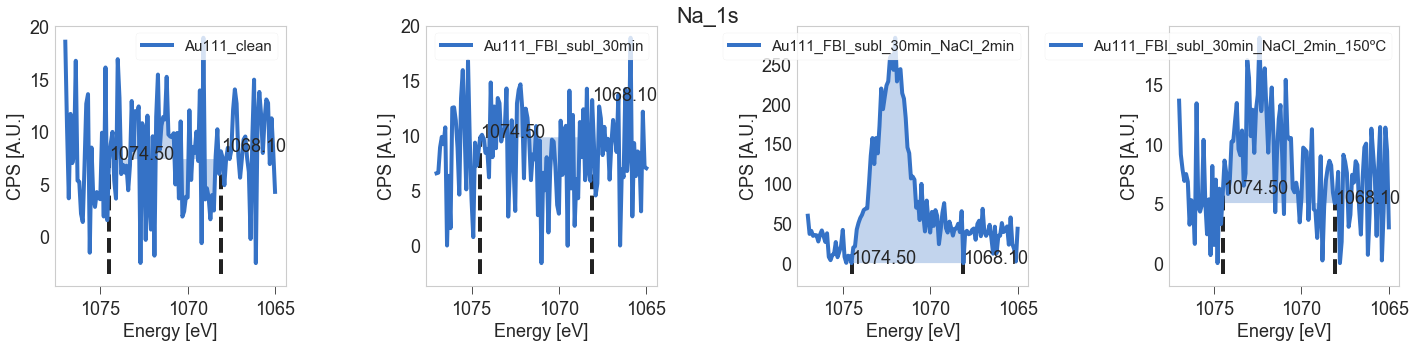

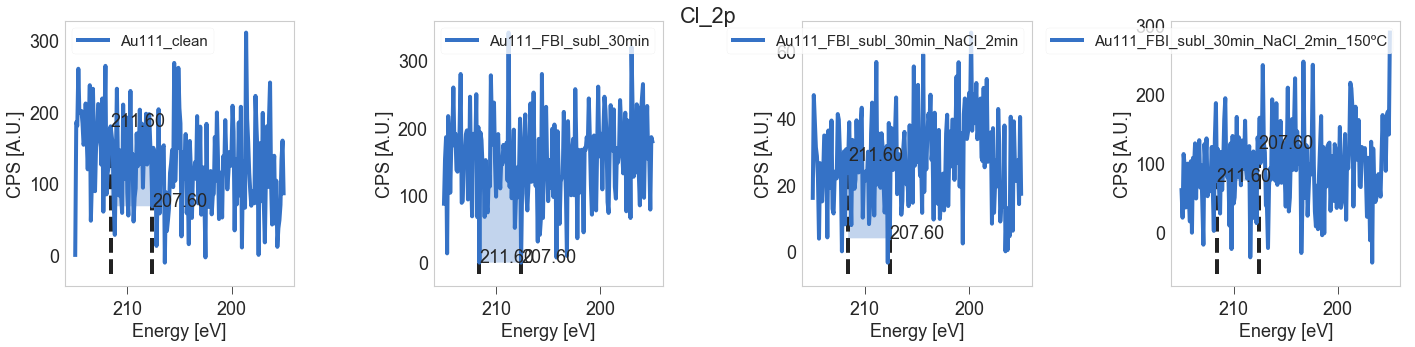

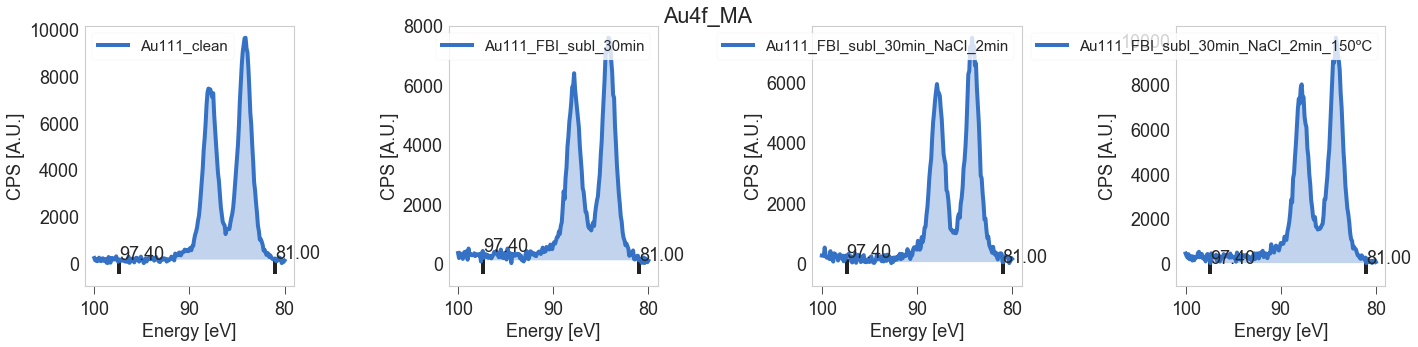

In [324]:
for r in regs:
    integrateRegions(samp1, r, asf=asf)

In [325]:
num, denom = (('N_1s', 'C_1s', 'C_1s' ), ('O_1s', 'N_1s', 'O_1s',))
make_stoichometry_table(samp1,  num=num, denom=denom, sep=' \t ')

num, denom = ('N_1s', 'Cl_2p'), ( 'Na_1s', 'Na_1s')
make_stoichometry_table([samp1[0]],  num=num, denom=denom, sep=' \t ')


Experiment	N_/O_	C_/N_	C_/O_	
Au111_clean 	 8.46  	  16.84  	  142.46  	  
Au111_FBI_subl_30min 	 0.95  	  6.61  	  6.25  	  
Au111_FBI_subl_30min_NaCl_2min 	 0.82  	  7.67  	  6.27  	  
Au111_FBI_subl_30min_NaCl_2min_150ºC 	 0.01  	  309.77  	  4.19  	  
Experiment	N_/Na_	Cl_/Na_	
Au111_clean 	 6.26  	  20.52  	  


## Coverages

In [331]:
# Coverage with FBI: IMFP = 1.86 nm
inds = [[1, 0]]
layers_fbi = arrange_coverages(samp1, inds,
                               r_ml = 1.1*nm, region='Au4f_MA', mfp = 3.87*nm, takeoff = 10)

# Coverage with BaCl2: IMFP = 1.35 nm
# Take previous stage (only FBI) as reference
inds = [[2, 1]]
layers_fbi = arrange_coverages(samp1, inds,
                               r_ml = 1*nm, region='Au4f_MA', mfp = 2.55*nm, takeoff = 10)

In [334]:
samp1[3].area.pop('layers')

-0.8239773601556797

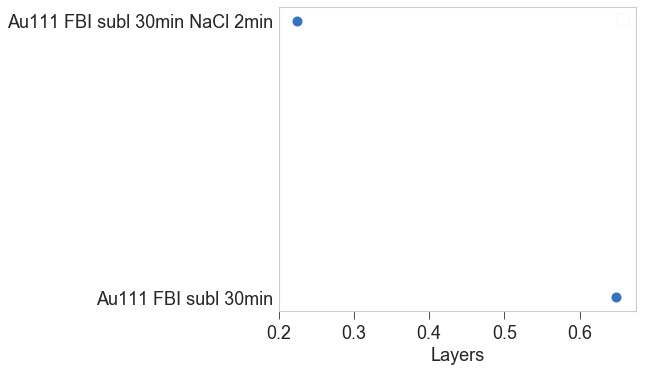

In [335]:
plot_coverages(samp1)

## Fits

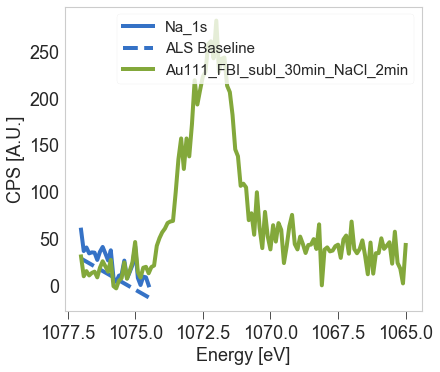

In [339]:
fix_tail_bg(samp1[2], 'Na_1s', edw=1074.5, inplace =True);

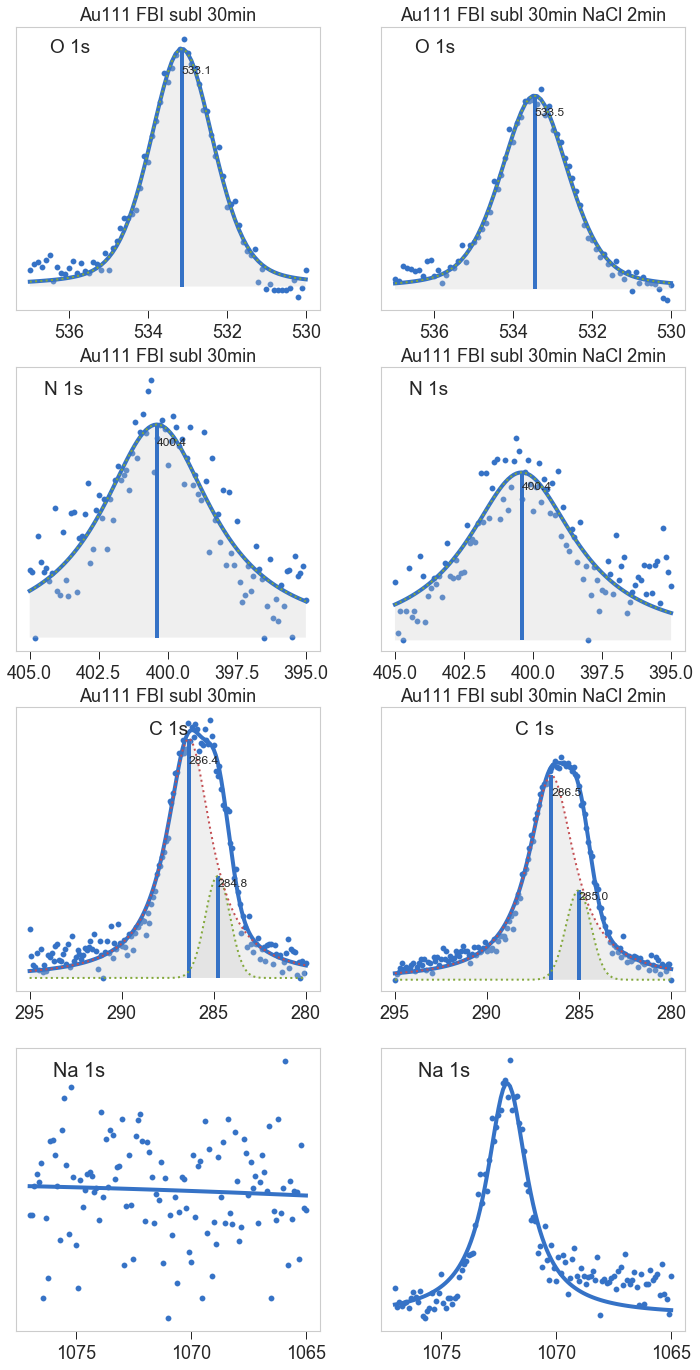

In [340]:
fig, ax = plt.subplots(4, 2, sharex=False, figsize=(12, 24), )

r = 'O_1s'
for i, xp in enumerate(samp1[1:3]):
    Fn = XPFit(xp, region = r)
#     Fn.preset_pars('v1_sigma', 0.92)
#     Fn.double_voigt(sepPt=531.5)
    Fn.voigt()
    Fn.set_areas()
    plot_fit_result(xp, r, fitRes=xp.fit[r], ax=ax[0][i], offset=0,
                    flag_fill=True, plot_comps=True)
    ax[0][i].set(title=xp.name.replace('_', ' '), xlabel='', ylabel='', yticks=[], 
                 ylim=(ax[0][i].get_ylim()[0], ax[0][0].get_ylim()[1]))
    ax[0][i].invert_xaxis()
    ax[0][i].tick_params('both', length=8, width=1, which='major')
    ax[0][i].text(s='O 1s', x=536.5, y=ax[0][0].get_ylim()[1]*0.9, fontsize=19)

r = 'N_1s'
for i, xp in enumerate(samp1[1:3]):
    Fn = XPFit(xp, region = r)
#     Fn.preset_pars('v1_sigma', 0.92)
    Fn.voigt()
#     Fn.voigt()
    Fn.set_areas()
    plot_fit_result(xp, r, fitRes=xp.fit[r], ax=ax[1][i], offset=0,
                    flag_fill=True, plot_comps=True)
    ax[1][i].set(title=xp.name.replace('_', ' '), xlabel='', ylabel='', yticks=[], 
                 ylim=(ax[1][i].get_ylim()[0], ax[1][0].get_ylim()[1]))
    ax[1][i].invert_xaxis()
    ax[1][i].tick_params('both', length=8, width=1, which='major')
    ax[1][i].text(s='N 1s', x=404.5, y=ax[1][0].get_ylim()[1]*0.9, fontsize=19)

r = 'C_1s'
for i, xp in enumerate(samp1[1:3]):
    Fn = XPFit(xp, region = r)
    if i == 2: Fn.preset_pars('v1_sigma', 1.033460)
    Fn.double_voigt(sepPt=286)
#     Fn.voigt()
    Fn.set_areas()
    plot_fit_result(xp, r, fitRes=xp.fit[r], ax=ax[2][i], offset=0,
                    flag_fill=True, plot_comps=True)
    ax[2][i].set(title=xp.name.replace('_', ' '), xlabel='', ylabel='', yticks=[], 
                 ylim=(ax[2][i].get_ylim()[0], ax[2][0].get_ylim()[1]))
    ax[2][i].invert_xaxis()
    ax[2][i].tick_params('both', length=8, width=1, which='major')
    ax[2][i].text(s='C 1s', x=288.5, y=ax[2][0].get_ylim()[1]*0.9, fontsize=19)

r = 'Na_1s'
for i,xp in enumerate(samp1[1:3]):
    Fn = XPFit(xp, region = r)
    Fn.voigt()
    Fn.set_areas()
    li = plot_fit_result(xp, r, fitRes=xp.fit[r], ax=ax[3][i], flag_fill=True, plot_comps=False)
    ax[3][i].set(xlabel='', ylabel='', yticks=[])
    ax[3][i].invert_xaxis()
    ax[3][i].tick_params('both', length=8, width=1, which='major',)
    ax[3][i].text(s='Na 1s', x=1076, y=ax[3][i].get_ylim()[1]*0.9, fontsize=20)

Modify user pars
Modify user pars
Modify user pars


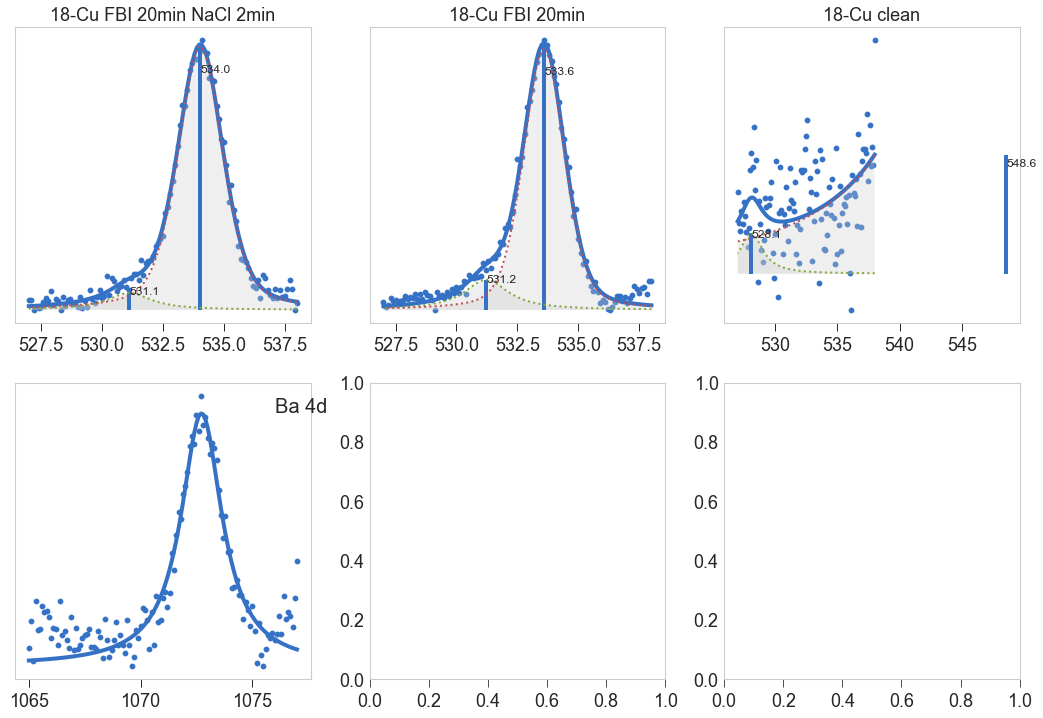

In [56]:
fig, ax = plt.subplots(2, 3, sharex=False, figsize=(18, 12), )

r = 'O_1s'
for i, xp in enumerate(samp1):
    Fn = XPFit(xp, region = r)
    if (i == 4):
        Fn.voigt()
    else:
        Fn.preset_pars('v1_sigma', 1.097)
        Fn.double_voigt(sepPt=532)
    Fn.set_areas()
    plot_fit_result(xp, r, fitRes=xp.fit[r], ax=ax[0][i], offset=0,
                    flag_fill=True, plot_comps=True)
    ax[0][i].set(title=xp.name.replace('_', ' '), xlabel='', ylabel='', yticks=[])
    ax[0][i].invert_xaxis()
    ax[0][i].tick_params('both', length=8, width=1, which='major')
#     ax[0][i].text(s='O 1s', x=537.5, y=ax[0][0].get_ylim()[1]*0.9, fontsize=20)

r = 'Na_1s'

for i,xp in enumerate([samp1[0]]):
    Fn = XPFit(xp, region = r)
    if i == 0: Fn.voigt()
    else:    Fn.double_voigt(sepPt=92.5)
    Fn.set_areas()
    li = plot_fit_result(xp, r, fitRes=xp.fit[r], ax=ax[1][i], flag_fill=True, plot_comps=False)
    ax[1][i].set(xlabel='', ylabel='', yticks=[])
    ax[1][i].invert_xaxis()
    ax[1][i].tick_params('both', length=8, width=1, which='major',)
    ax[1][i].text(s='Ba 4d', x=1076, y=ax[1][i].get_ylim()[1]*0.9, fontsize=20)
# plt.tight_layout(w_pad=0.5, h_pad=0.5, pad=0.1)
# ax[0][0].legend(list(li.get_lines()), labels = [xp.name for xp in samp1[:0:-1]], ncol=len(selection),
#             loc="upper left", bbox_to_anchor=(0.1, 1.2))  

In [346]:
samp1[1].color = 'g'
samp1[2].color = 'b'

[[]]

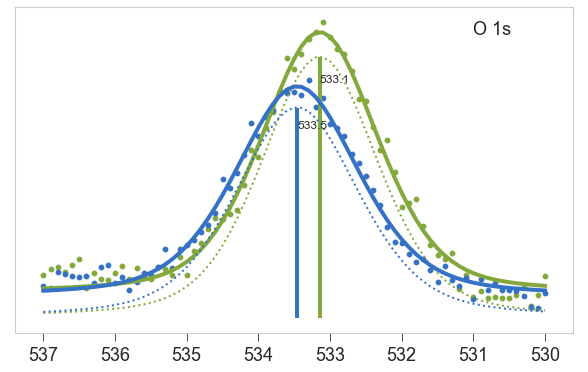

In [357]:
plt.figure(figsize=(10, 6))
plot_fit_result(samp1[1], 'O_1s')
plot_fit_result(samp1[2], 'O_1s')
plt.text(s='O 1s', x=531, y = 450)
plt.gca().invert_xaxis()
plt.gca().set(yticks=[])
# plt.legend()

[[]]

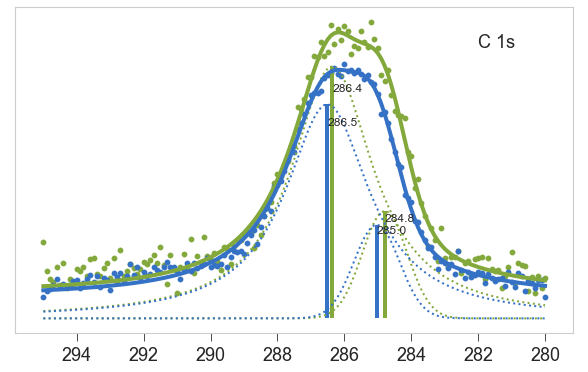

In [356]:
region = 'C_1s'
plt.figure(figsize=(10, 6))
plot_fit_result(samp1[1], region)
plot_fit_result(samp1[2], region)
plt.text(s=region.replace('_',' '), x=282, y = 550)
plt.gca().invert_xaxis()
plt.gca().set(yticks=[])
# plt.legend()

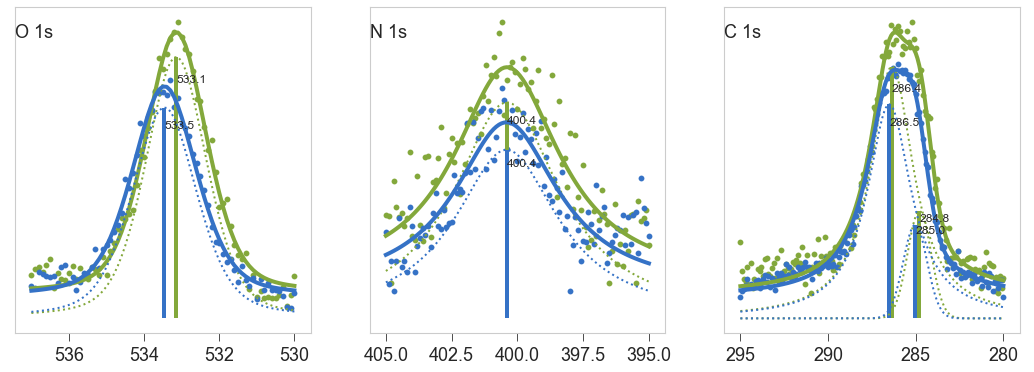

In [363]:
regions = ['O_1s', 'N_1s', 'C_1s']
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
for i, region in enumerate(regions):
    plot_fit_result(samp1[1], region, ax=ax[i])
    plot_fit_result(samp1[2], region, ax=ax[i])
    ax[i].invert_xaxis()
    ax[i].text(s=region.replace('_',' '), x=ax[i].get_xlim()[0], y = ax[i].get_ylim()[1]*0.9)
    ax[i].set(yticks=[])
# plt.legend(loc='upper left')

In [341]:
for xp in samp1:
    write_processed_xp(xp.path, xp)

Storing of file /Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_07_Au111/proc/20210507_Au111_clean.uxy.ft successful
Storing of file /Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_07_Au111/proc/20210507_Au111_FBI_subl_30min.uxy.ft successful
Storing of file /Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_07_Au111/proc/20210508_Au111_FBI_subl_30min_NaCl_2min.uxy.ft successful
Storing of file /Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_07_Au111/proc/20210508_Au111_FBI_subl_30min_NaCl_2min_150ºC.uxy.ft successful


# All samples O 1s shoulder vs Ba layers

In [165]:
samp17[1].name

'FBI_60min'

In [137]:
np.sqrt(xp.area['O_1s_v1_'] * (xp.area['O_1s']) ) / xp.area['O_1s']

0.014388008144192384

In [185]:
for xp in samp12[1:6:3]:
    print(xp.name)

11-Cu_FBI_subl_20min_BaCl2_2min
12-Cu_FBI_subl_20min_BaCl2_4min


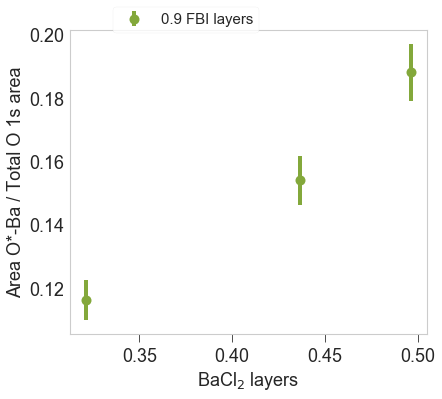

In [194]:
cov12, shoulder12, dshoulder12 = [], [], []
for xp in samp12[1:6:3]:
    cov12.append(xp.area['layers'])
    shoulder12.append(xp.area['O_1s_v1_'])
    dshoulder12.append(np.sqrt(xp.area['O_1s_v1_'] * (xp.area['O_1s']) ) / xp.area['O_1s'] )

# plt.errorbar(x=cov12, y=shoulder12, yerr=dshoulder12, fmt='o',ms=10, label='%.1f FBI layers' %samp12[0].area['layers'])

cov13, shoulder13, dshoulder13 = [], [], []
for xp in samp13[2:]:
    cov13.append(xp.area['layers'])
    shoulder13.append(xp.area['O_1s_v1_'])
    dshoulder13.append(np.sqrt(xp.area['O_1s_v1_'] * (xp.area['O_1s']) ) / xp.area['O_1s'] )

plt.errorbar(x=cov13, y=shoulder13, yerr=dshoulder13, fmt='go',ms=10, label='%.1f FBI layers' %samp13[1].area['layers'])
# plt.plot(cov13, shoulder13, 'og', ms=10, label='%.1f FBI layers' %samp13[1].area['layers'])
plt.xlabel('BaCl$_2$ layers')
plt.ylabel('Area O*-Ba / Total O 1s area')
plt.gca().legend(loc="upper left", bbox_to_anchor=(0.1, 1.1))  

FBI_60min_BaCl2_1min
FBI_60min_BaCl2_2min
FBI_60min_BaCl2_6min


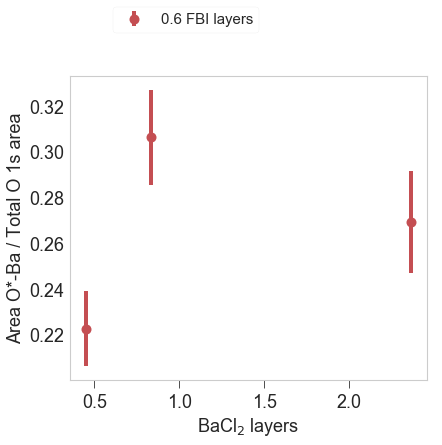

In [190]:
cov16, shoulder16, dshoulder16 = [], [], []
for xp in subml[2:5]:
    cov16.append(xp.area['layers'])
    shoulder16.append(xp.area['O_1s_v1_'])
    dshoulder16.append(np.sqrt(xp.area['O_1s_v1_'] * (xp.area['O_1s']) ) / xp.area['O_1s'] )
    
plt.errorbar(x=cov16, y=shoulder16, yerr=dshoulder16, fmt='ro',ms=10, label='%.1f FBI layers' %subml[1].area['layers'])

cov17, shoulder17, dshoulder17 = [], [], []
for xp in samp17[2:5]:
    print(xp.name)
    cov17.append(xp.area['layers'])
    shoulder17.append(xp.area['O_1s_v1_'])
    dshoulder17.append(np.sqrt(xp.area['O_1s_v1_'] * (xp.area['O_1s']) ) / xp.area['O_1s'] )
    
# plt.errorbar(x=cov17, y=shoulder17, yerr=dshoulder17, fmt='ok',ms=10, label='%.1f FBI layers' %samp17[1].area['layers'])
plt.xlabel('BaCl$_2$ layers')
plt.ylabel('Area O*-Ba / Total O 1s area')
plt.gca().legend(loc="upper left", bbox_to_anchor=(0.1, 1.25))  

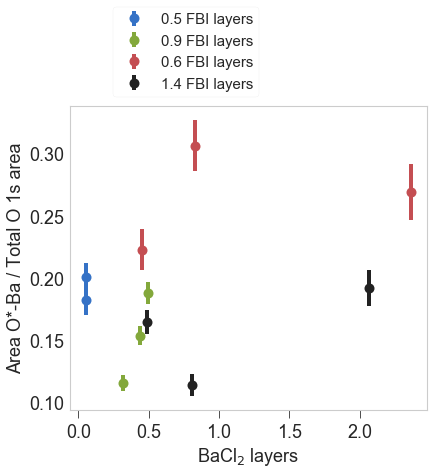

In [187]:
plt.errorbar(x=cov12, y=shoulder12, yerr=dshoulder12, fmt='o',ms=10, label='%.1f FBI layers' %samp12[0].area['layers'])
plt.errorbar(x=cov13, y=shoulder13, yerr=dshoulder13, fmt='o',ms=10, label='%.1f FBI layers' %samp13[1].area['layers'])
plt.errorbar(x=cov16, y=shoulder16, yerr=dshoulder16, fmt='ro',ms=10, label='%.1f FBI layers' %subml[1].area['layers'])
plt.errorbar(x=cov17, y=shoulder17, yerr=dshoulder17, fmt='ok',ms=10, label='%.1f FBI layers' %samp17[1].area['layers'])
plt.xlabel('BaCl$_2$ layers')
plt.ylabel('Area O*-Ba / Total O 1s area')
plt.gca().legend(loc="upper left", bbox_to_anchor=(0.1, 1.35))  